In [1]:
import pandas as pd

datasets = {
  "dataset_pca": pd.read_csv("../../dataset/dataset_pca.csv"),
  "dataset_features": pd.read_csv("../../dataset/dataset_selected_pred.csv"),
}

In [2]:
features = {
  "dataset_pca": datasets["dataset_pca"].drop('Target', axis=1),
  "dataset_features": datasets["dataset_features"].drop('target', axis=1),
}

target = {
  "dataset_pca": datasets["dataset_pca"]['Target'],
  "dataset_features": datasets["dataset_features"]['target'],
}

Value Counts for Target:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


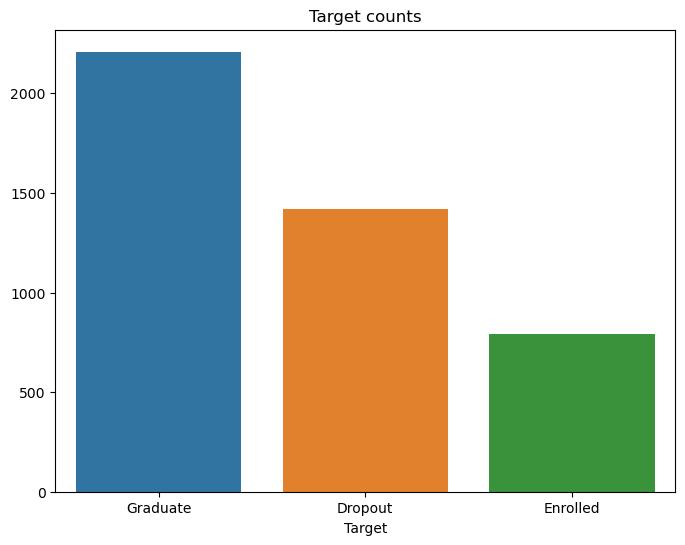

Value Counts for Target:
target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


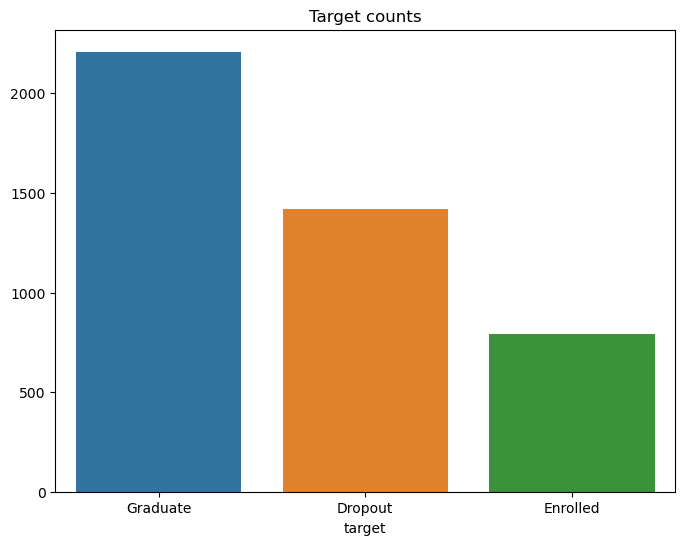

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

target_counts = list(map(lambda x: x.value_counts(), target.values()))

for tgt in target_counts:
  print(f"Value Counts for Target:\n{tgt}")
  plt.figure(figsize=(8,6))
  sns.barplot(x=tgt.index, y=tgt.values, hue=tgt.index)
  plt.title('Target counts')
  plt.show()

After OverSampling, the shape of train_X: (6627, 8)
After OverSampling, the shape of train_y: (6627,) 

Value Counts for Target:
Target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64


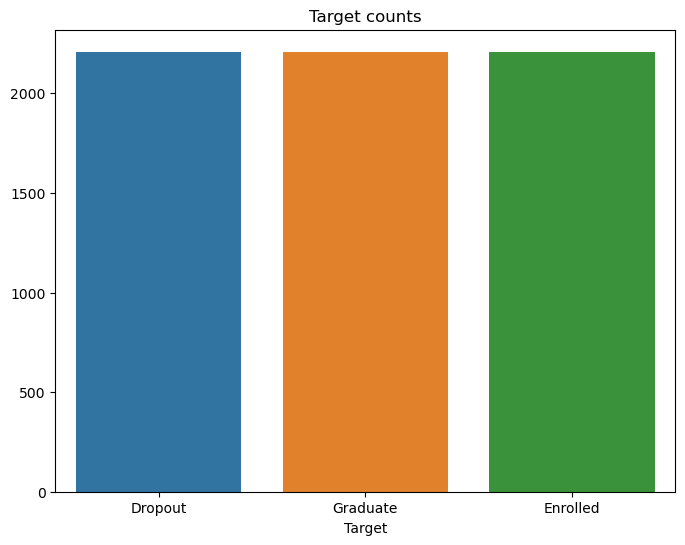

After OverSampling, the shape of train_X: (6627, 17)
After OverSampling, the shape of train_y: (6627,) 

Value Counts for Target:
target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64


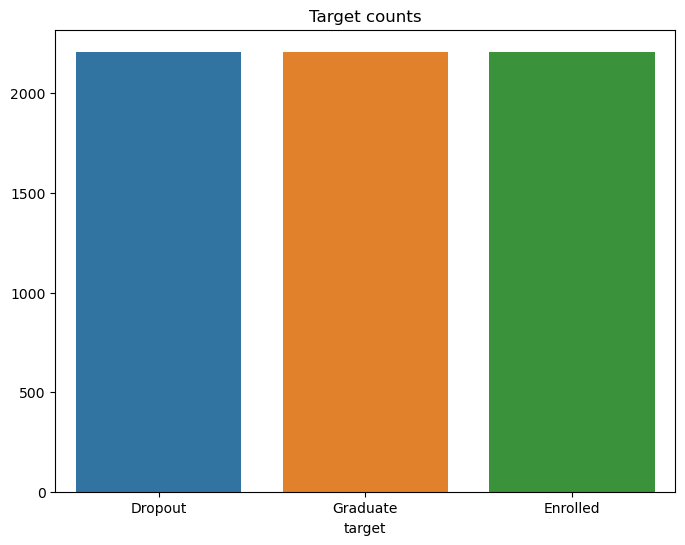

In [4]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

X = {}
y = {}

for key in features.keys():
  features_train_res, target_train_res = sm.fit_resample(features[key], target[key])
  X[key] = features_train_res
  y[key] = target_train_res

  print('After OverSampling, the shape of train_X: {}'.format(features_train_res.shape))
  print('After OverSampling, the shape of train_y: {} \n'.format(target_train_res.shape))

  print(f"Value Counts for Target:\n{target_train_res.value_counts()}")
  plt.figure(figsize=(8,6))
  sns.barplot(x=target_train_res.value_counts().index, y=target_train_res.value_counts().values, hue=target_train_res.value_counts().index)
  plt.title('Target counts')
  plt.show()

In [5]:
from sklearn.model_selection import train_test_split 

def split_data(X, y, train_size, test_size, val_size):
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, random_state=42, train_size=train_size, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, random_state=42, train_size=test_size/(test_size + val_size), shuffle=True)
    return X_train, X_test, X_val, y_train, y_test, y_val

# Data split explanation:
# First split (train vs rest):
#   - Training set: 70% of data (X_train, y_train)
#   - Remaining: 30% of data (for test and validation)
#
# Second split (test vs validation):
#   - Test set: 2/3 of remaining data = 20% of total data (X_test, y_test)
#   - Validation set: 1/3 of remaining data = 10% of total data (X_val, y_val)
#
# Final distribution:
#   - Training: 70%
#   - Testing: 20%
#   - Validation: 10%

train = {}
test = {}
val = {}

for key in X.keys():
  X_train, X_test, X_val, y_train, y_test, y_val = split_data(X[key], y[key], 0.7, 0.2, 0.1)
  train[key] = (X_train, y_train)
  test[key] = (X_test, y_test)
  val[key] = (X_val, y_val)
  
  training_data = pd.concat([X_train, y_train], axis=1)
  testing_data = pd.concat([X_test, y_test], axis=1)
  validation_data = pd.concat([X_val, y_val], axis=1)

  # Check if the distribution is correct
  total = X[key].shape[0]
  print(f"Training data distribution {(training_data.value_counts().sum() / total):.0%}")
  print(f"Testing data distribution {(testing_data.value_counts().sum() / total):.0%}")
  print(f"Validation data distribution {(validation_data.value_counts().sum() / total):.0%}")

Training data distribution 70%
Testing data distribution 20%
Validation data distribution 10%
Training data distribution 70%
Testing data distribution 20%
Validation data distribution 10%


### **Support Vector Machine (SVM)**

Support Vector Machine (SVM) is a supervised machine learning algorithm used primarily for classification tasks, but it can also be applied to regression. SVM works by finding the hyperplane that best separates different classes in the feature space, maximizing the margin between data points of different classes.

#### Key Features:

-   **Classification**: SVM excels in binary and multi-class classification problems.
-   **Margin Maximization**: It tries to find the optimal hyperplane that maximizes the margin between different classes, which helps improve model generalization.
-   **Kernel Trick**: SVM can handle non-linear data by using kernel functions, transforming the feature space into a higher-dimensional space for better separation.
-   **Support Vectors**: The data points that are closest to the hyperplane are called support vectors, which are crucial in determining the optimal hyperplane.


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

svm_model = SVC()

# Define the grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernels for SVM
    'gamma': ['scale', 'auto'],           # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                   # Degree for the polynomial kernel
}

grid_search = GridSearchCV(
  estimator=svm_model, 
  param_grid=param_grid, 
  scoring='accuracy', 
  cv=5,          # 5-fold cross-validation
  verbose=1,     # Print messages
  n_jobs=-1      # Use all CPU cores for parallelization
  )     

In [ ]:
grid_search_results = {}

for key in train.keys():
  X_train, y_train = train[key]
  X_val, y_val = val[key]
  X_test, y_test = test[key]

  # Step 4: Fit the model on the training set
  print(f"Training the model on {key} dataset")
  grid_search.fit(X_train, y_train)

  # Step 5: Best parameters and model performance
  print("Best Parameters:", grid_search.best_params_)
  print("Best Training Accuracy:", grid_search.best_score_)

  # Step 6: Evaluate on the Validation Set
  best_model = grid_search.best_estimator_
  y_val_pred = best_model.predict(X_val)
  print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")
  print("Classification Report:\n", classification_report(y_val, y_val_pred))

  # Step 7: Evaluate on the Test Set
  y_test_pred = best_model.predict(X_test)
  print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
  print("Classification Report:\n", classification_report(y_test, y_test_pred))
  
  grid_search_results[key] = grid_search.cv_results_

  # Save the model
  import joblib

  joblib.dump(best_model, f"svm_model_{key}.pkl")

Training the model on dataset_pca dataset
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Accuracy: 0.7121601011791839
Validation Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

     Dropout       0.83      0.69      0.75       207
    Enrolled       0.66      0.71      0.68       229
    Graduate       0.73      0.79      0.76       227

    accuracy                           0.73       663
   macro avg       0.74      0.73      0.73       663
weighted avg       0.74      0.73      0.73       663

Test Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

     Dropout       0.89      0.71      0.79       474
    Enrolled       0.65      0.72      0.68       421
    Graduate       0.70      0.79      0.74       431

    accuracy                           0.74      1326
   macro avg       0.75      0

In [ ]:
for key in grid_search_results.keys():
  df_results = pd.DataFrame(grid_search_results[key])

  fig, ax = plt.subplots(1, 2, figsize=(15, 6))
  sns.lineplot(data=df_results, x='param_C', y='mean_test_score', hue='param_kernel', style='param_gamma', ax=ax[0], markers=True, dashes=False, err_style=None)
  sns.lineplot(data=df_results, x='param_C', y='mean_fit_time', hue='param_kernel', style='param_gamma', ax=ax[1], markers=True, dashes=False, err_style=None)

  plt.show()